<a href="https://colab.research.google.com/github/ashini18/-Smart-Task-Scheduler-System-Using-Priority-Queue-/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install optional packages (run once)
!pip install -q shap

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
from google.colab import files
uploaded = files.upload()  # use the upload widget and select train.csv

# load dataset (adjust filename if different)
df = pd.read_csv('train.csv')
print("Loaded shape:", df.shape)
df.head()


Saving train.csv to train (1).csv
Loaded shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Basic info & summary
print("Columns:", len(df.columns))
print(df.info())
display(df.describe(include='all').T)

# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.head(20)  # show top 20 columns with missing values


Columns: 81
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1460.0,NaN,NaN,NaN,6.321918,2.703626,1.0,5.0,6.0,8.0,12.0
YrSold,1460.0,NaN,NaN,NaN,2007.815753,1.328095,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1460,9,WD,1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1460,6,Normal,1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


In [ ]:
# We'll apply a simple, safe strategy:
# - Numeric columns -> fill median
# - Categorical columns -> fill mode (most frequent)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Fill numeric
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Fill categorical
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# Verify no missing left
print("Missing after fill:", df.isnull().sum().sum())


Missing after fill: 0


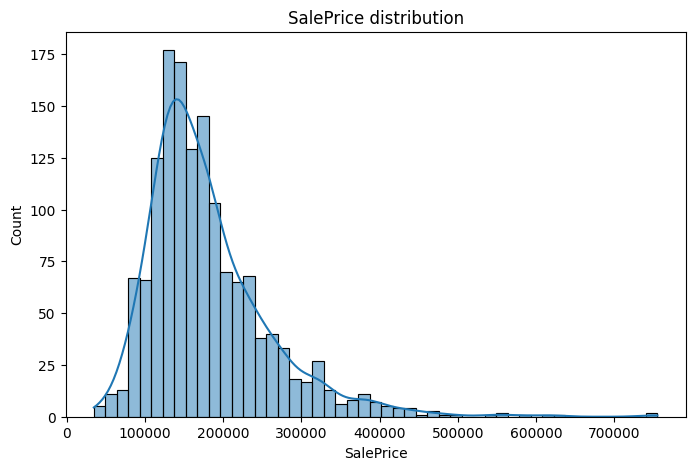

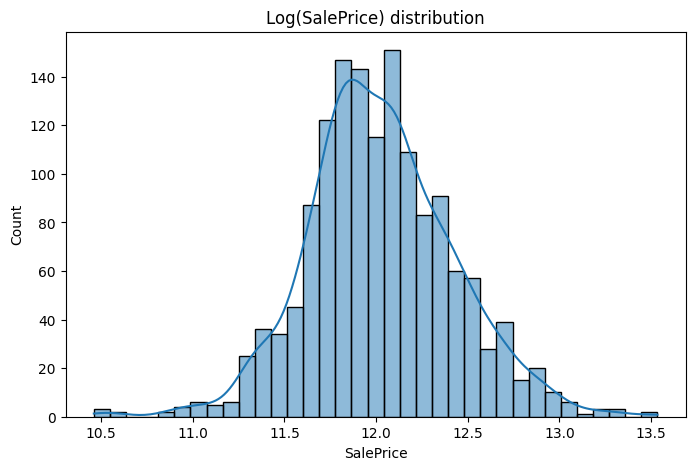

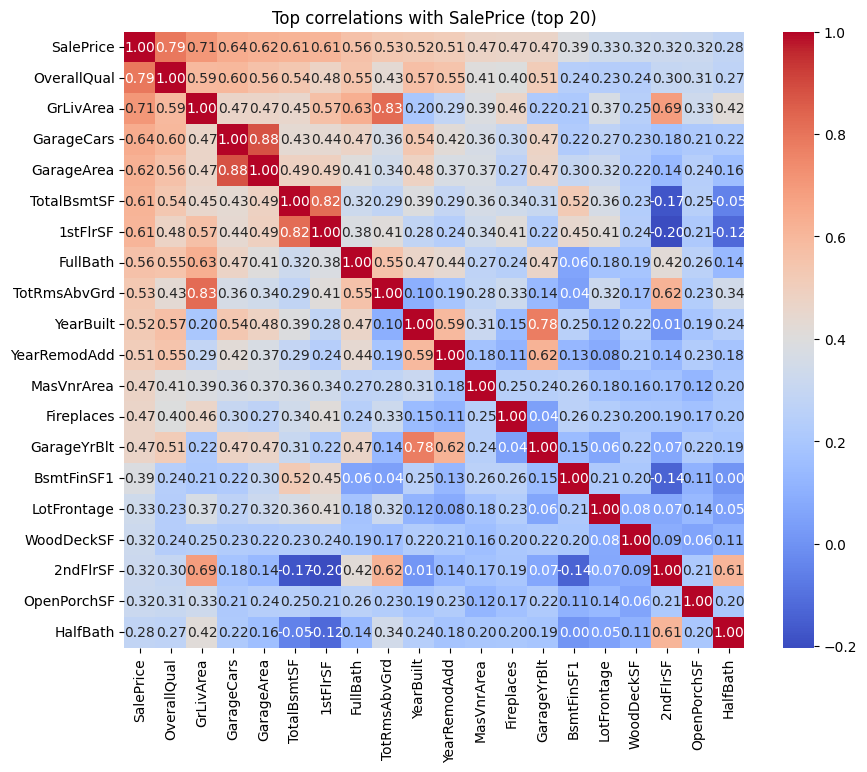

In [ ]:
# SalePrice distribution
plt.figure(figsize=(8,5))
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.show()

# Log-transform often helps for price
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df['SalePrice']), kde=True)
plt.title('Log(SalePrice) distribution')
plt.show()

# Simple correlation heatmap for top features
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
top_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(20).index
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df[top_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Top correlations with SalePrice (top 20)')
plt.show()

In [ ]:
# We'll start with a small, interpretable feature set (you can expand later)
features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
    'FullBath', 'YearBuilt', 'LotArea', 'TotRmsAbvGrd'
]
target = 'SalePrice'

# Quick check that features exist
for f in features:
    if f not in df.columns:
        print("Missing feature:", f)

X = df[features].copy()
y = df[target].copy()

print("X shape:", X.shape, "y shape:", y.shape)
X.head()


X shape: (1460, 8) y shape: (1460,)


,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,FullBath,YearBuilt,LotArea,TotRmsAbvGrd
0,7,1710,856,2,2,2003,8450,8
1,6,1262,1262,2,2,1976,9600,6
2,7,1786,920,2,2,2001,11250,6
3,7,1717,756,3,1,1915,9550,7
4,8,2198,1145,3,2,2000,14260,9


from matplotlib import pyplot as plt
_df_16['OverallQual'].plot(kind='hist', bins=20, title='OverallQual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['GrLivArea'].plot(kind='hist', bins=20, title='GrLivArea')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['TotalBsmtSF'].plot(kind='hist', bins=20, title='TotalBsmtSF')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['GarageCars'].plot(kind='hist', bins=20, title='GarageCars')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='OverallQual', y='GrLivArea', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='GrLivArea', y='TotalBsmtSF', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='TotalBsmtSF', y='GarageCars', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='GarageCars', y='FullBath', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['OverallQual']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('OverallQual')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['GrLivArea']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('GrLivArea')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['TotalBsmtSF']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('TotalBsmtSF')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['FullBath']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('FullBath')

from matplotlib import pyplot as plt
_df_28['OverallQual'].plot(kind='line', figsize=(8, 4), title='OverallQual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['GrLivArea'].plot(kind='line', figsize=(8, 4), title='GrLivArea')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['TotalBsmtSF'].plot(kind='line', figsize=(8, 4), title='TotalBsmtSF')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['GarageCars'].plot(kind='line', figsize=(8, 4), title='GarageCars')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Example: create house_age and total_rooms (illustrative)
df['HouseAge'] = df['YearBuilt'].max() - df['YearBuilt']
X['HouseAge'] = df['HouseAge']
# If you added HouseAge to X, you might drop YearBuilt for modeling
X = X.drop(columns=['YearBuilt'], errors='ignore')

X.head()


,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,FullBath,LotArea,TotRmsAbvGrd,HouseAge
0,7,1710,856,2,2,8450,8,7
1,6,1262,1262,2,2,9600,6,34
2,7,1786,920,2,2,11250,6,9
3,7,1717,756,3,1,9550,7,95
4,8,2198,1145,3,2,14260,9,10


from matplotlib import pyplot as plt
_df_0['OverallQual'].plot(kind='hist', bins=20, title='OverallQual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['GrLivArea'].plot(kind='hist', bins=20, title='GrLivArea')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['TotalBsmtSF'].plot(kind='hist', bins=20, title='TotalBsmtSF')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['GarageCars'].plot(kind='hist', bins=20, title='GarageCars')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='OverallQual', y='GrLivArea', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='GrLivArea', y='TotalBsmtSF', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='TotalBsmtSF', y='GarageCars', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='GarageCars', y='FullBath', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['OverallQual']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('OverallQual')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['GrLivArea']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('GrLivArea')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['TotalBsmtSF']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('TotalBsmtSF')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['GarageCars']
  ys = series['FullBath']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('GarageCars', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GarageCars')
_ = plt.ylabel('FullBath')

from matplotlib import pyplot as plt
_df_12['OverallQual'].plot(kind='line', figsize=(8, 4), title='OverallQual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['GrLivArea'].plot(kind='line', figsize=(8, 4), title='GrLivArea')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['TotalBsmtSF'].plot(kind='line', figsize=(8, 4), title='TotalBsmtSF')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['GarageCars'].plot(kind='line', figsize=(8, 4), title='GarageCars')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# scale numeric features (Linear Regression benefits)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train: (1168, 8) Test: (292, 8)


In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

lr_results = regression_metrics(y_test, y_pred_lr)
print("Linear Regression results:", lr_results)


Linear Regression results: {'MAE': 24805.193348157354, 'MSE': 1567868804.610968, 'RMSE': np.float64(39596.32311984243), 'R2': 0.7955929432125235}


In [ ]:
# Decision Tree (no scaling needed but we can use scaled data for consistency)
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_results = regression_metrics(y_test, y_pred_dt)
print("Decision Tree results:", dt_results)


Decision Tree results: {'MAE': 23640.138015394947, 'MSE': 1266200568.646192, 'RMSE': np.float64(35583.71212572112), 'R2': 0.8349222009019959}


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_results = regression_metrics(y_test, y_pred_rf)
print("Random Forest results:", rf_results)


Random Forest results: {'MAE': 18497.661054305285, 'MSE': 808702935.5000997, 'RMSE': np.float64(28437.70271136717), 'R2': 0.8945673347318212}


,Model,MAE,RMSE,R2
0,LinearRegression,24805.193348,39596.323120,0.795593
1,DecisionTree,23640.138015,35583.712126,0.834922
2,RandomForest,18497.661054,28437.702711,0.894567


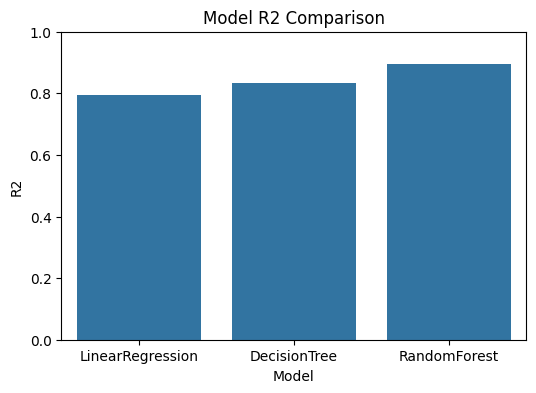

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['R2']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('R2', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['R2']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('R2', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['R2']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'R2'}, axis=1)
              .sort_values('R2', ascending=True))
  xs = counted['R2']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('R2', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
results_df = pd.DataFrame({
    'Model': ['LinearRegression', 'DecisionTree', 'RandomForest'],
    'MAE': [lr_results['MAE'], dt_results['MAE'], rf_results['MAE']],
    'RMSE': [lr_results['RMSE'], dt_results['RMSE'], rf_results['RMSE']],
    'R2': [lr_results['R2'], dt_results['R2'], rf_results['R2']]
})
display(results_df)

# Barplot for R2
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='R2', data=results_df)
plt.title('Model R2 Comparison')
plt.ylim(0,1)
plt.show()


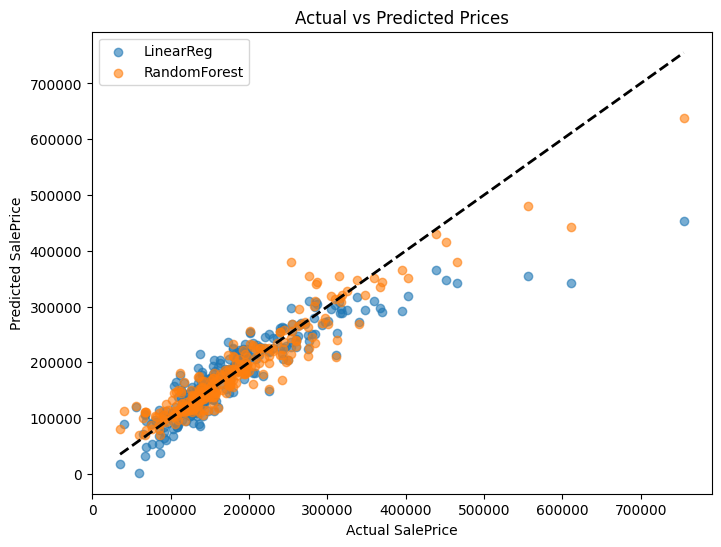

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, label='LinearReg', alpha=0.6)
plt.scatter(y_test, y_pred_rf, label='RandomForest', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()


,feature,importance
0,OverallQual,0.578501
1,GrLivArea,0.174029
2,TotalBsmtSF,0.092848
5,LotArea,0.050203
7,HouseAge,0.049582
3,GarageCars,0.027540
6,TotRmsAbvGrd,0.015348
4,FullBath,0.011949


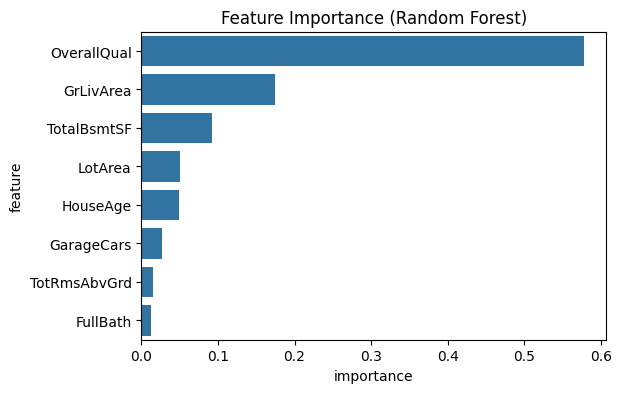

from matplotlib import pyplot as plt
_df_32['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_34.groupby('feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='index', y='importance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_38['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_38, x='index', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_39['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_39, x='importance', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

display(fi)
plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=fi)
plt.title('Feature Importance (Random Forest)')
plt.show()


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 12],
    'min_samples_split': [2, 5]
}
gscv = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                    param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gscv.fit(X_train, y_train)
print("Best params:", gscv.best_params_)
best_rf = gscv.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Tuned RF R2:", r2_score(y_test, y_pred_best))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF R2: 0.8915226328429819


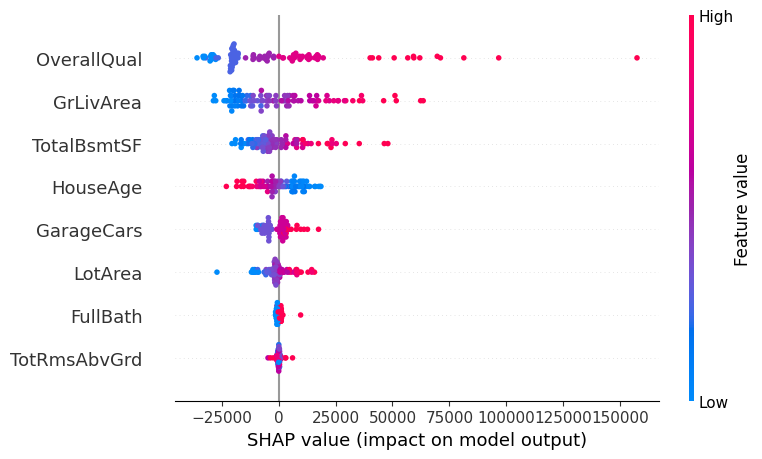

In [ ]:
import shap
# Use a small sample to compute shap values (faster)
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test.sample(100, random_state=42))

# Summary plot (opens in notebook)
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))


In [ ]:
import joblib
joblib.dump(lr, 'linear_regression_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save results table
results_df.to_csv('model_results.csv', index=False)

# Download files to your local machine (Colab link)
from google.colab import files
files.download('model_results.csv')
files.download('linear_regression_model.pkl')
files.download('random_forest_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>